In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Load dataset
df = pd.read_csv("/content/iot_sensor_data_with_anomalies.csv")

# Drop timestamp and label for training
X = df.drop(columns=["Timestamp", "Label"])
y_true = df["Label"]  # Save the true labels

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use only normal data (Label = 0) to train the VAE
X_normal = X_scaled[y_true == 0]

# Split into training and validation sets
X_train, X_val = train_test_split(X_normal, test_size=0.1, random_state=42)


In [34]:

input_dim = X_train.shape[1]
latent_dim = 2

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(32, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
decoder_outputs = layers.Dense(input_dim)(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }


vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=lambda y_true, y_pred: 0.0)

In [35]:
vae.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val))


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - kl_loss: 0.0266 - loss: 0.2345 - reconstruction_loss: 0.2079 - val_loss: 0.0000e+00
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0080 - loss: 0.1869 - reconstruction_loss: 0.1789 - val_loss: 0.0000e+00
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.0044 - loss: 0.1755 - reconstruction_loss: 0.1711 - val_loss: 0.0000e+00
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0033 - loss: 0.1696 - reconstruction_loss: 0.1663 - val_loss: 0.0000e+00
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 0.0026 - loss: 0.1672 - reconstruction_loss: 0.1646 - val_loss: 0.0000e+00
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.0021 - loss: 0.1641 - reconstruction_loss: 0.1620 - val_loss: 0.0000e+00
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0017 - loss: 0.1632 - reconstruction_loss: 0.1615 - val_loss: 0.0000e+00
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

In [36]:
# Reconstruct all data
X_pred = vae.predict(X_scaled)
reconstruction_error = tf.keras.losses.mse(X_scaled, X_pred).numpy()

# Set a threshold for anomaly detection
threshold = reconstruction_error[y_true == 0].mean() + 2 * reconstruction_error[y_true == 0].std()
print("Anomaly threshold:", threshold)

# Predict anomalies
y_pred = [1 if err > threshold else 0 for err in reconstruction_error]

# Accuracy
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Anomaly threshold: 0.21324825
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1000
           1       0.59      1.00      0.74        50

    accuracy                           0.97      1050
   macro avg       0.79      0.98      0.86      1050
weighted avg       0.98      0.97      0.97      1050



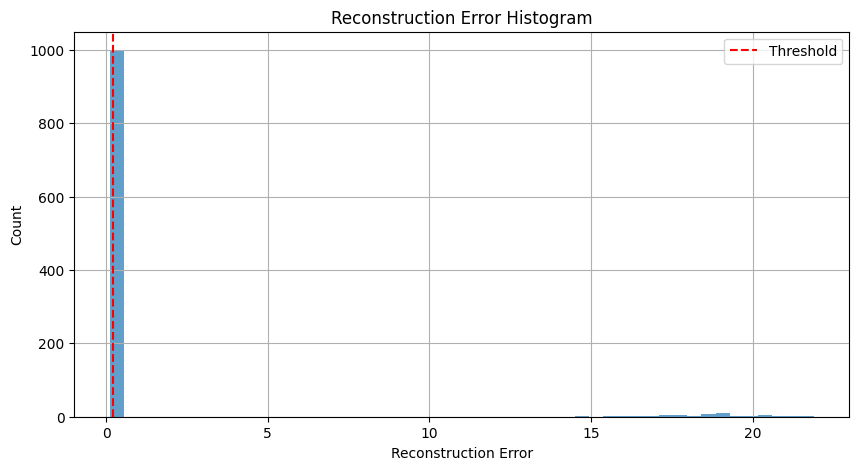

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50, alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Histogram")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()
